In [2]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# import the datasets
dfInteract = pd.read_csv("beers/RAW_interactions.csv")
dfRecipes = pd.read_csv("beers/RAW_recipes.csv")

## Data Overview

### Dataset #1

In [5]:
dfInteract.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [6]:
dfInteract.shape

(1132367, 5)

In [7]:
dfInteract.dtypes

user_id       int64
recipe_id     int64
date         object
rating        int64
review       object
dtype: object

In [8]:
dfInteract.isna().sum() / len(dfInteract) # missingness

user_id      0.000000
recipe_id    0.000000
date         0.000000
rating       0.000000
review       0.000149
dtype: float64

In [9]:
# correcting data type
dfInteract['date'] = pd.to_datetime(dfInteract.date)

# dropping columns with nan values in review
dfInteract.dropna(axis = 0, inplace = True)

### Dataset #2

In [10]:
dfRecipes.head()
# nutrition: calories (#), total fat (PDV), sugar (PDV), sodium (PDV), protein (PDV), saturated fat

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [11]:
dfRecipes.shape

(231637, 12)

In [33]:
dfRecipes.dtypes

name                      object
id                         int64
minutes                    int64
contributor_id             int64
submitted         datetime64[ns]
tags                      object
nutrition                 object
n_steps                    int32
steps                     object
description               object
ingredients               object
n_ingredients              int64
dtype: object

In [13]:
dfRecipes.isna().sum() / len(dfRecipes)

name              0.000004
id                0.000000
minutes           0.000000
contributor_id    0.000000
submitted         0.000000
tags              0.000000
nutrition         0.000000
n_steps           0.000000
steps             0.000000
description       0.021495
ingredients       0.000000
n_ingredients     0.000000
dtype: float64

In [84]:
# correcting data types
dfRecipes['submitted'] = pd.to_datetime(dfRecipes.submitted)
dfRecipes['n_steps'] = dfRecipes.n_steps.astype('int')

# dropping columns with nan values in description and name
dfRecipes.dropna(axis=0, inplace=True)

# dropping an outlier
dfRecipes = dfRecipes[dfRecipes.minutes < max(dfRecipes.minutes)]

## Exploratory Data Analysis

### Dataset #1

In [15]:
dfInteract.head(3)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...


In [16]:
# what is the rating out of?
print(f'Minimum Rating: {min(dfInteract.rating)}')
print(f'Maximum Rating: {max(dfInteract.rating)}')

Minimum Rating: 0
Maximum Rating: 5


In [17]:
dfInteract[['rating']].describe().round(2)

,rating
count,1132198.00
mean,4.41
std,1.26
min,0.00
25%,4.00
50%,5.00
75%,5.00
max,5.00


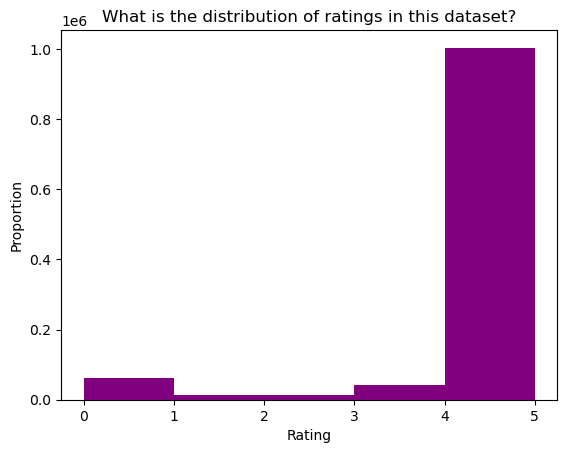

In [ ]:
plt.hist(list(dfInteract['rating']), bins=[0, 1, 2, 3, 4, 5], color='purple');
plt.title('What is the distribution of ratings in this dataset?')
plt.xlabel('Rating');
plt.ylabel('Proportion'); # mostly 4s and 5s

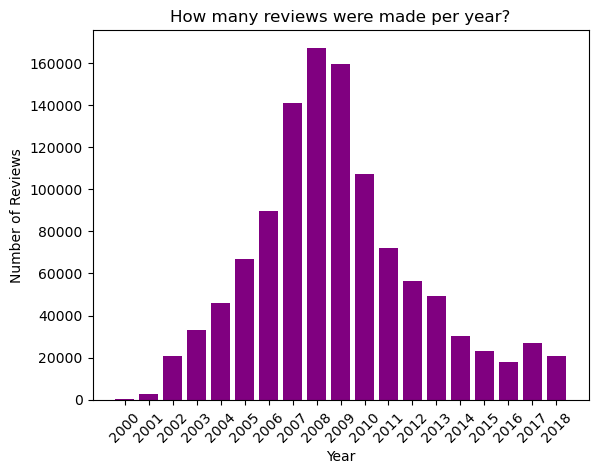

In [44]:
dfInteract['year'] = dfInteract.date.transform(lambda d: d.year)

grouped_year = dfInteract.year.value_counts()

plt.bar(grouped_year.index, grouped_year.values, color = 'purple');
plt.xticks(grouped_year.index, rotation=45);
plt.title('How many reviews were made per year?')
plt.xlabel('Year');
plt.ylabel('Number of Reviews'); # lots of reviews in 2008

In [42]:
dfInteract['review_length'] = dfInteract.review.transform(lambda r: len(r))

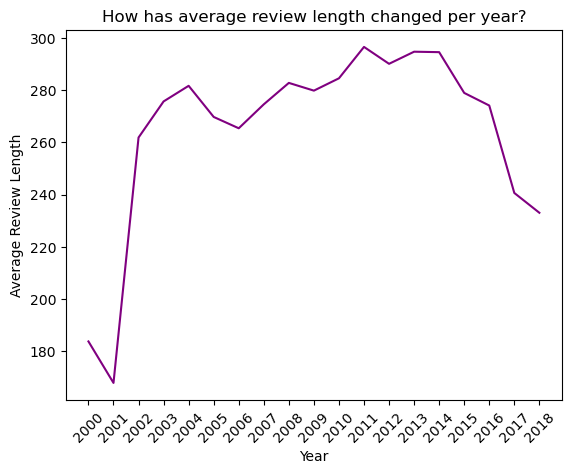

In [ ]:
grouped_reviewLen = dfInteract.groupby('year')['review_length'].mean()

plt.plot(grouped_reviewLen.index, grouped_reviewLen.values, color = 'purple');
plt.xticks(grouped_reviewLen.index, rotation=45);
plt.title('How has average review length changed per year?')
plt.xlabel('Year');
plt.ylabel('Average Review Length'); # inconsistent average review length

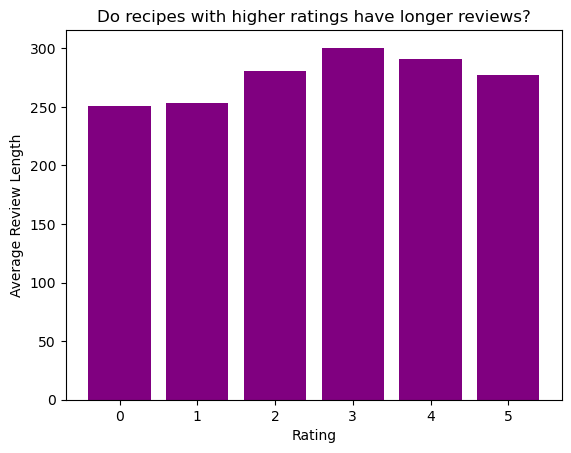

In [ ]:
grouped_review = dfInteract.groupby('rating')['review_length'].mean()

plt.bar(grouped_review.index, grouped_review.values, color = 'purple');
plt.xticks(grouped_review.index);
plt.title('Do recipes with higher ratings have longer reviews?')
plt.xlabel('Rating');
plt.ylabel('Average Review Length'); # no.

### Dataset #2

In [85]:
dfRecipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [86]:
dfRecipes[['minutes','n_steps', 'n_ingredients']].describe().round(2)

,minutes,n_steps,n_ingredients
count,226656.00,226656.00,226656.00
mean,127.88,9.77,9.05
std,2955.63,6.00,3.74
min,0.00,0.00,1.00
25%,20.00,6.00,6.00
50%,40.00,9.00,9.00
75%,65.00,12.00,11.00
max,1051200.00,145.00,43.00


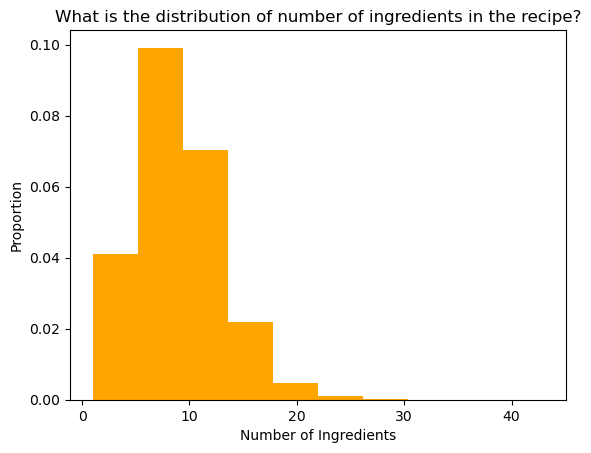

In [175]:
plt.hist(list(dfRecipes['n_ingredients']), density=True, color='orange');
plt.title('What is the distribution of number of ingredients in the recipe?')
plt.xlabel('Number of Ingredients');
plt.ylabel('Proportion');

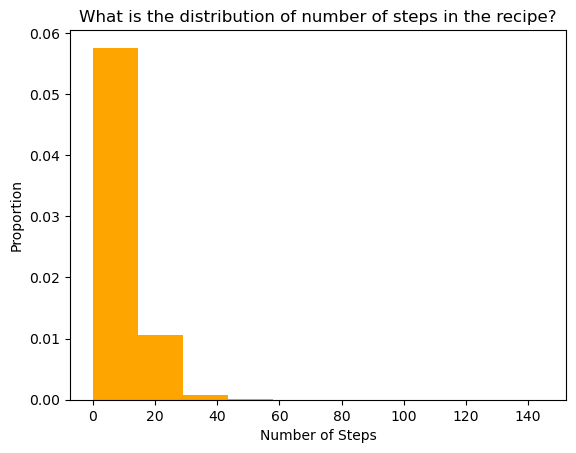

In [174]:
plt.hist(list(dfRecipes['n_steps']), density=True, color='orange');
plt.title('What is the distribution of number of steps in the recipe?')
plt.xlabel('Number of Steps');
plt.ylabel('Proportion');

In [151]:
ingredient_dict = {}

for ingredients in list(dfRecipes.ingredients):
    ingredients = ingredients.strip('[]')
    ingredients = ingredients.split(', ')
    for ingredient in ingredients:
        ingredient = str(ingredient.strip("'"))
        if ingredient not in ingredient_dict:
            ingredient_dict[ingredient] = 1
        else:
            ingredient_dict[ingredient] += 1

In [120]:
print(f'Number of Ingredients: {len(ingredient_dict)}')

Number of Ingredients: 14745


In [154]:
top_ingredients = []

for key in ingredient_dict.keys():
    top_ingredients.append((ingredient_dict[key], key))
    
top_ingredients.sort()
top_ingredients.reverse()
top_ingredients[:10]

[(83781, 'salt'),
 (53788, 'butter'),
 (43419, 'sugar'),
 (38168, 'onion'),
 (34060, 'water'),
 (33055, 'eggs'),
 (32245, 'olive oil'),
 (25663, 'flour'),
 (25643, 'garlic cloves'),
 (25235, 'milk')]

The top ingredients in this dataset are salt, butter, sugar, onion, water, eggs, olive oil, flour, garlic cloves, and milk.

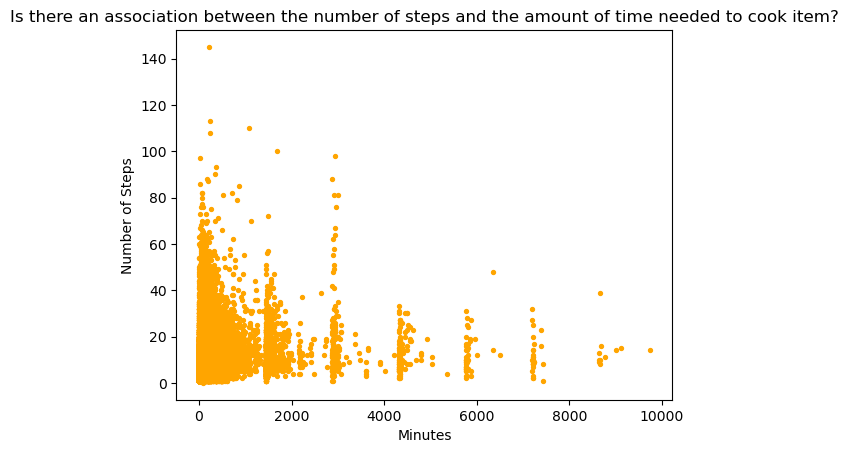

In [166]:
mins_subset = dfRecipes[dfRecipes.minutes < 10000]

plt.scatter(x=mins_subset.minutes, y=mins_subset.n_steps, s = 8, color='orange');
plt.title('Is there an association between the number of steps and the amount of time needed to cook item?');
plt.xlabel('Minutes');
plt.ylabel('Number of Steps'); # negative correlation, but not conclusive?

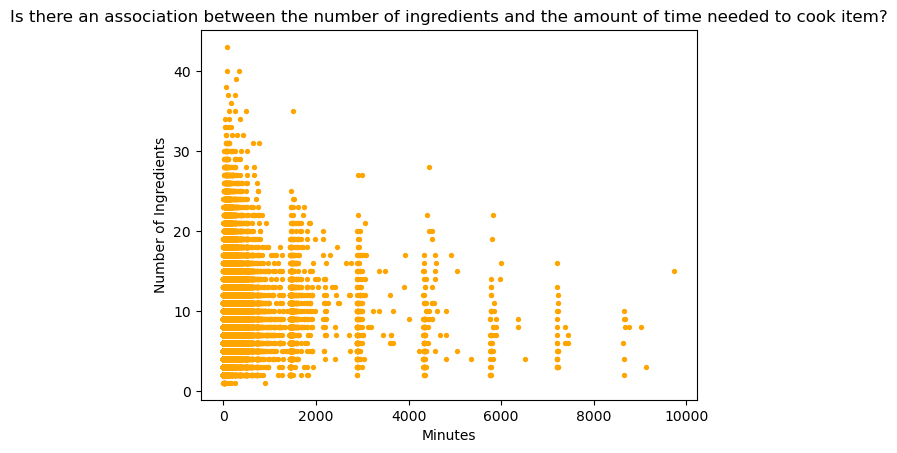

In [167]:
plt.scatter(x=mins_subset.minutes, y=mins_subset.n_ingredients, s = 8, color='orange');
plt.title('Is there an association between the number of ingredients and the amount of time needed to cook item?');
plt.xlabel('Minutes');
plt.ylabel('Number of Ingredients'); # negative correlation, but not conclusive?

In [176]:
dfInteractionsNew = dfInteract[['recipe_id', 'review']]
dfInteractionsNew.rename(columns={'recipe_id': 'id'}, inplace=True)

In [177]:
# clean the interactions dataset, combining all the reviews for a recipe into one review so we can run through it with tfidf
combinedReviewsDict = {}
for i in range(0,len(dfInteract)):
    row = dfInteractionsNew.iloc[i,:]
    foodID = row['id']
    foodReview = row['review']
    if foodID not in combinedReviewsDict:
        combinedReviewsDict[foodID] = ""
    if foodReview == foodReview:
        combinedReviewsDict[foodID] = combinedReviewsDict[foodID] + " " + foodReview

combinedReviewsList = []
for id in combinedReviewsDict:
    combinedReviewsList.append([id, combinedReviewsDict[id]])

dfInteractionsNewNew = pd.DataFrame(combinedReviewsList, columns=["id", "review"])

In [178]:
dfInteractionsNewNew

,id,review
0,40893,Great with a salad. Cooked on top of stove fo...
1,44394,This worked very well and is EASY. I used no...
2,85009,I made the Mexican topping and took it to bun...
3,120345,very very sweet. after i waited the 2 days i ...
4,134728,Very good! Better than the real!! Absolutely ...
...,...,...
231625,470995,Just as the title promised this is a lovely s...
231626,241491,I made this over the weekend and changed it u...
231627,257796,Very tender and juicy - had trouble getting ...
231628,72730,Another approach is to start making sauce wit...


In [179]:
dfRecipesNew = dfRecipes[['name', 'id', 'description', 'ingredients']]

In [180]:
# merge the reviews and the recipe details
merged_df = pd.merge(dfRecipesNew, dfInteractionsNewNew, on='id', how='inner')

In [182]:
merged_df.head()

,name,id,description,ingredients,review
0,arriba baked winter squash mexican style,137739,autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",I used an acorn squash and recipe#137681 Swe...
1,a bit different breakfast pizza,31490,this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...","Have not tried this, but it sounds delicious...."
2,all in the kitchen chili,112140,this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",I added black beans and corn to this and LOVE...
3,alouette potatoes,59389,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...","This is an excellent, easy-fix side-dish w/to..."
4,amish tomato ketchup for canning,44061,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...","I wasn't sure how this was going to turn out,..."


Experimenting with library here!

In [189]:
# Import nltk package 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [202]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [203]:
tfidf = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=2000, tokenizer=word_tokenize)

In [204]:
def preprocess(string): 
    string = string.replace('\n', ' ')
    string = re.sub(r'[^\w\s]|_', ' ', string)
    string = re.sub(r'\s+', ' ', string).lower().strip()
    
    return string

In [210]:
sentence = preprocess(merged_df.iloc[0].description)
sentence

'autumn is my favorite time of year to cook this recipe can be prepared either spicy or sweet your choice two of my posted mexican inspired seasoning mix recipes are offered as suggestions'